This worksheet takes a look at street-level crime in the UK during the five-year period from January 2012 until December 2016 (inclusive). The data is publicly available from data.police.uk. 

After downloading the data, we read the numerous CSV files into the notebook. 

Libraries we'll need:

In [1]:
import math as m
import pylab
import numpy as np
import pandas as pd
%matplotlib inline
import glob
import csv

import matplotlib.pyplot as plt
import matplotlib.cm

from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
from shapely.geometry import Polygon
from descartes import PolygonPatch

Here we collect the files for Street crime and for Stop and Search, across all the Forces. It was decided to keep separate DataFrames for each year, for use later.

In [2]:
StreetFiles2012 = sorted(glob.glob('/Users/barinderbanwait/Downloads/CrimeStatsFive/2012*/*street.csv'))
StSFiles2012 = sorted(glob.glob('/Users/barinderbanwait/Downloads/CrimeStatsFive/2012*/*search.csv'))

StreetFiles2013 = sorted(glob.glob('/Users/barinderbanwait/Downloads/CrimeStatsFive/2013*/*street.csv'))
StSFiles2013 = sorted(glob.glob('/Users/barinderbanwait/Downloads/CrimeStatsFive/2013*/*search.csv'))

StreetFiles2014 = sorted(glob.glob('/Users/barinderbanwait/Downloads/CrimeStatsFive/2014*/*street.csv'))
StSFiles2014 = sorted(glob.glob('/Users/barinderbanwait/Downloads/CrimeStatsFive/2014*/*search.csv'))

StreetFiles2015 = sorted(glob.glob('/Users/barinderbanwait/Downloads/CrimeStatsFive/2015*/*street.csv'))
StSFiles2015 = sorted(glob.glob('/Users/barinderbanwait/Downloads/CrimeStatsFive/2015*/*search.csv'))

StreetFiles2016 = sorted(glob.glob('/Users/barinderbanwait/Downloads/CrimeStatsFive/2016*/*street.csv'))
StSFiles2016 = sorted(glob.glob('/Users/barinderbanwait/Downloads/CrimeStatsFive/2016*/*search.csv'))

StreetFiles = StreetFiles2012+StreetFiles2013+StreetFiles2014+StreetFiles2015+StreetFiles2016

We'll now collate the Street stats into a single Dataframe. (We'll look at Stop and search a bit later.). Note that these files have lots of useless columns which we won't need, so we'll only read in the columns that we care about. 

In [3]:
DesiredColumns = ['Month','Reported by','Crime type']
StreetData = pd.concat([pd.read_csv(f,usecols=DesiredColumns) for f in StreetFiles], ignore_index=True)


'StreetData' now contains all the street crime data across the whole of the UK. Let's count how many crimes were reported in each force.

<font size="4"><center><big><b>Crime Rate per Force, taken over the last five years</font></center></big></b>

Let's begin by counting how many crimes were reported in each force.

In [4]:
TotalCrimesByForce = StreetData['Reported by'].value_counts()
print(TotalCrimesByForce)

Metropolitan Police Service           5023809
Greater Manchester Police             1654395
West Yorkshire Police                 1319863
West Midlands Police                  1250940
South Yorkshire Police                 919273
Lancashire Constabulary                880818
Hampshire Constabulary                 869355
Thames Valley Police                   828196
Avon and Somerset Constabulary         811963
Police Service of Northern Ireland     806628
Kent Police                            801525
Northumbria Police                     795232
Essex Police                           795065
Merseyside Police                      770735
Sussex Police                          714066
Devon & Cornwall Police                649696
South Wales Police                     649291
West Mercia Police                     568010
Nottinghamshire Police                 544624
Derbyshire Constabulary                495161
Staffordshire Police                   492367
Cheshire Constabulary             

Let's see how that looks in a $\pi$ chart. 

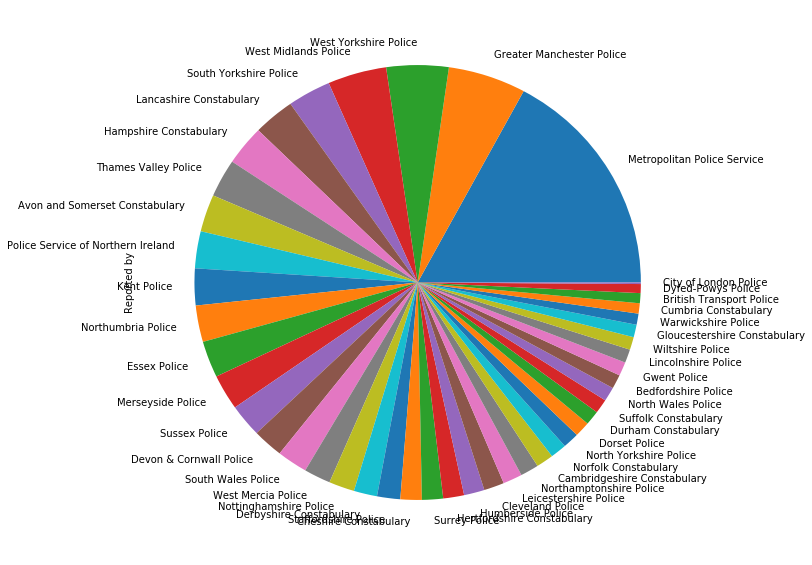

In [5]:
TotalCrimesByForce.plot(kind='pie',figsize=(10,10))

Hmmm, the Met seems to have far more than its fair share of crimes. Or does it? To really say that, we'd need to see the number of people living within each of the forces' jurisdictions. A few minutes of googling brings the following data for population per police force, found from the gov.uk website. 

In [6]:
Populations = pd.read_csv("/Users/barinderbanwait/Downloads/UKPopulationbyPoliceForce.csv",index_col=0)

So now we'll look at the Crime Rate by force. (We assume for simplicity that these populations have remained constant during the last five years; these numbers surely can't have changed significantly in that time.)

In [7]:
CrimeRateByForce = pd.concat([TotalCrimesByForce.sort_index(),Populations.sort_index()],axis=1)
CrimeRateByForce['Crime Rate']=CrimeRateByForce['Reported by']/CrimeRateByForce['Mid 2010']
print(CrimeRateByForce)

                                    Reported by   Mid 2010  Crime Rate
Avon and Somerset Constabulary           811963  1623200.0    0.500224
Bedfordshire Police                      305895   614800.0    0.497552
British Transport Police                 218438        NaN         NaN
Cambridgeshire Constabulary              368544   789700.0    0.466689
Cheshire Constabulary                    452704  1009300.0    0.448533
City of London Police                     33417    11700.0    2.856154
Cleveland Police                         431182   563500.0    0.765185
Cumbria Constabulary                     224843   494400.0    0.454780
Derbyshire Constabulary                  495161  1010600.0    0.489967
Devon & Cornwall Police                  649696  1680400.0    0.386632
Dorset Police                            331703   715000.0    0.463920
Durham Constabulary                      311318   611600.0    0.509022
Dyfed-Powys Police                       195409   506100.0    0.386107
Essex 

Let's see that on a traditional bar chart

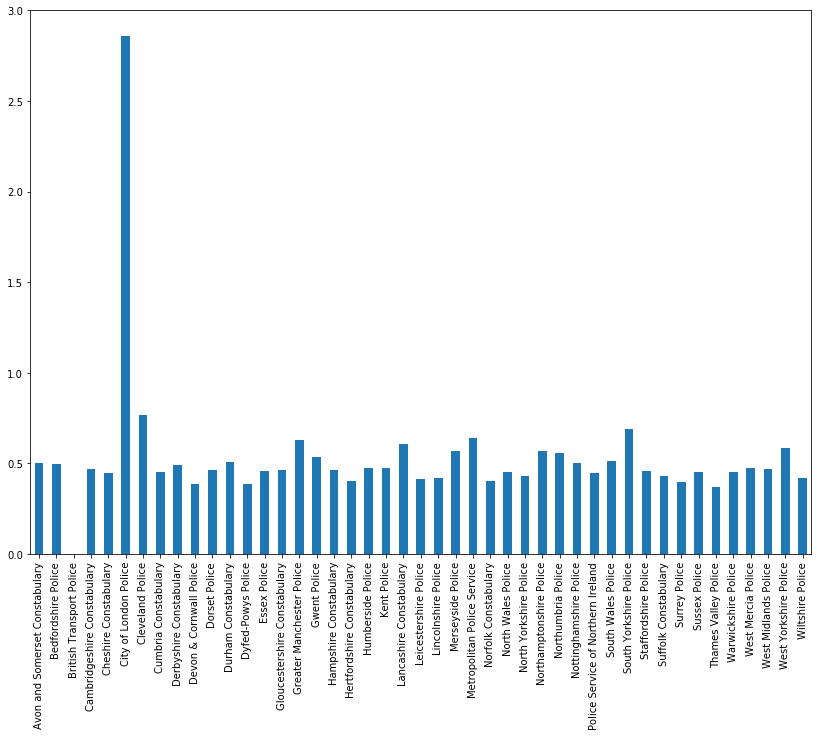

In [8]:
CrimeRateByForce['Crime Rate'].plot(kind='bar',figsize=(14,10))

Woah! What's going on in the City of London?!? Maybe it's so hign due to its tiny population...

The following shows that the City of London is way beyond the third quartile:

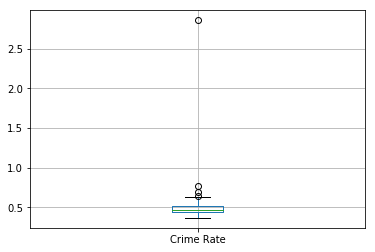

In [9]:
CrimeRateByForce.boxplot(column='Crime Rate')

Since the City of London appears to present a special/anomalous case, let's remove it and see a histogram of the rest:

In [10]:
CrimeRateByForceLite=CrimeRateByForce.drop('City of London Police')

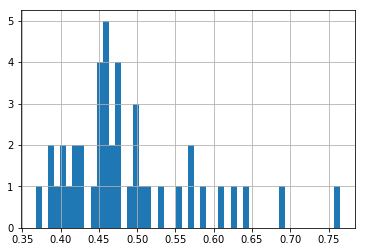

In [11]:
CrimeRateByForceLite['Crime Rate'].hist(bins=50)

Maybe a boxplot might give more insight:

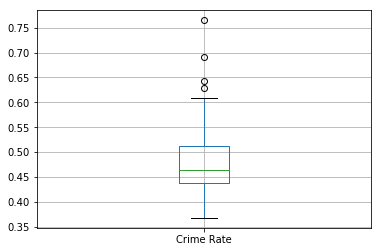

In [12]:
CrimeRateByForceLite.boxplot(column='Crime Rate')

Those two outliers - beyond the third quartile - are Cleveland and South Yorkshire. What's going on over there?

In [13]:
CrimeRateByForceLite.sort_values('Crime Rate',ascending=False)

,Reported by,Mid 2010,Crime Rate
Cleveland Police,431182,563500.0,0.765185
South Yorkshire Police,919273,1328300.0,0.692067
Metropolitan Police Service,5023809,7813500.0,0.642965
Greater Manchester Police,1654395,2629400.0,0.629191
Lancashire Constabulary,880818,1449300.0,0.607754
West Yorkshire Police,1319863,2249500.0,0.586736
Merseyside Police,770735,1353400.0,0.569481
Northamptonshire Police,390635,687300.0,0.568362
Northumbria Police,795232,1431500.0,0.555524
Gwent Police,300021,561400.0,0.534416


<font size="4"><center><big><b>Crime Rate per Force per year, last five years</font></center></big></b>

Firstly, let's compute the national crime rate for each of the last five years

In [99]:
Years=['2012','2013','2014','2015','2016']

StreetData2012 = pd.concat([pd.read_csv(f,usecols=DesiredColumns) for f in StreetFiles2012], ignore_index=True)
StreetData2013 = pd.concat([pd.read_csv(f,usecols=DesiredColumns) for f in StreetFiles2013], ignore_index=True)
StreetData2014 = pd.concat([pd.read_csv(f,usecols=DesiredColumns) for f in StreetFiles2014], ignore_index=True)
StreetData2015 = pd.concat([pd.read_csv(f,usecols=DesiredColumns) for f in StreetFiles2015], ignore_index=True)
StreetData2016 = pd.concat([pd.read_csv(f,usecols=DesiredColumns) for f in StreetFiles2016], ignore_index=True)

NationalCrimesTotal=[len(StreetData2012),len(StreetData2013),len(StreetData2014),len(StreetData2015),len(StreetData2016)]

In [104]:
TotalPopulation = Populations['Mid 2010'].sum()
NationalCrimeRatePerYear = pd.Series([x/TotalPopulation for x in NationalCrimesTotal],index=Years)

In [105]:
NationalCrimeRatePerYear

2012    0.107341
2013    0.101047
2014    0.099150
2015    0.100887
2016    0.105845
dtype: float64

Let's see that on a graph:

Axes(0.125,0.125;0.775x0.755)


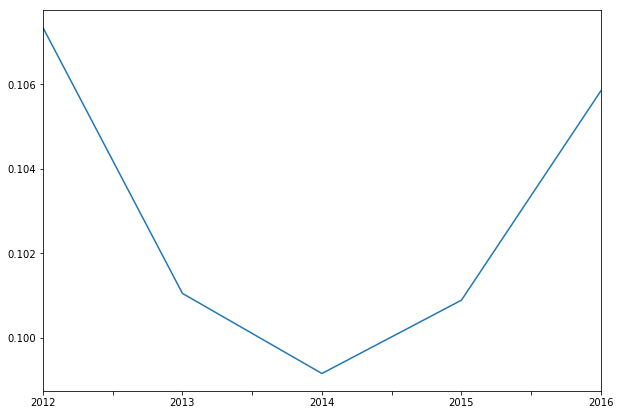

In [121]:
NationalPlot=NationalCrimeRatePerYear.plot(figsize=(10,7))
print(NationalCrimeRatePerYearPlot)

Is the apparently lower rate in 2014 significant (statistically)? We'll look into it...meanwhile, let's see how each force compares with this national picture.

In [116]:
CrimeRateByForce2012 = pd.concat([StreetData2012['Reported by'].value_counts().sort_index(),Populations.sort_index()],axis=1)
CrimeRateByForce2012['2012']=CrimeRateByForce2012['Reported by']/CrimeRateByForce2012['Mid 2010']
CrimeRateByForce2012 = CrimeRateByForce2012['2012']

CrimeRateByForce2013 = pd.concat([StreetData2013['Reported by'].value_counts().sort_index(),Populations.sort_index()],axis=1)
CrimeRateByForce2013['2013']=CrimeRateByForce2013['Reported by']/CrimeRateByForce2013['Mid 2010']
CrimeRateByForce2013 = CrimeRateByForce2013['2013']

CrimeRateByForce2014 = pd.concat([StreetData2014['Reported by'].value_counts().sort_index(),Populations.sort_index()],axis=1)
CrimeRateByForce2014['2014']=CrimeRateByForce2014['Reported by']/CrimeRateByForce2014['Mid 2010']
CrimeRateByForce2014 = CrimeRateByForce2014['2014']

CrimeRateByForce2015 = pd.concat([StreetData2015['Reported by'].value_counts().sort_index(),Populations.sort_index()],axis=1)
CrimeRateByForce2015['2015']=CrimeRateByForce2015['Reported by']/CrimeRateByForce2015['Mid 2010']
CrimeRateByForce2015 = CrimeRateByForce2015['2015']

CrimeRateByForce2016 = pd.concat([StreetData2016['Reported by'].value_counts().sort_index(),Populations.sort_index()],axis=1)
CrimeRateByForce2016['2016']=CrimeRateByForce2016['Reported by']/CrimeRateByForce2016['Mid 2010']
CrimeRateByForce2016 = CrimeRateByForce2016['2016']

In [117]:
CrimeRateByForceFiveYears = pd.concat([CrimeRateByForce2012,CrimeRateByForce2013,CrimeRateByForce2014,CrimeRateByForce2015,CrimeRateByForce2016],axis=1)

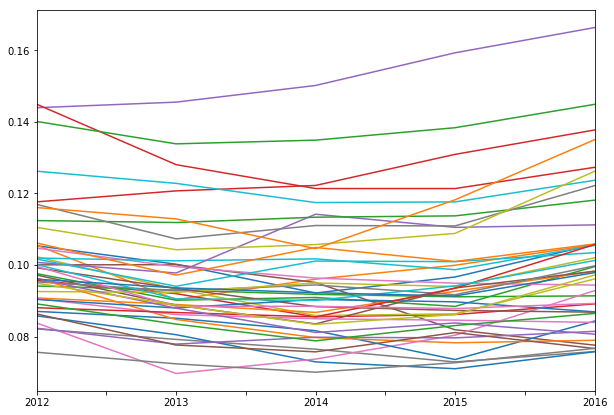

In [142]:
CrimeRateByForceFiveYears.drop(['British Transport Police','City of London Police']).transpose().plot(figsize=(10,7),legend=False)

TO DO: Insert legend in appropriate place. Try to untangle this.

Let's write a code to find those forces in which the crime rate has been decreasing over the five years

In [169]:
TheForces=CrimeRateByForceFiveYears.index

In [174]:
def IsDecreasing(x):
    i=0
    while (i <= 3) and (x[i] >= x[i+1]):
        i=i+1
    if i == 4:
        return True
    else:
        return False

In [179]:
DecreasingRateForces = []
for For in TheForces:
    Sig = CrimeRateByForceFiveYears.transpose()[For]
    if IsDecreasing(Sig):
        DecreasingRateForces.append(For)
print(DecreasingRateForces)

['Derbyshire Constabulary', 'North Wales Police', 'North Yorkshire Police']


Let's see these declines on a graph:

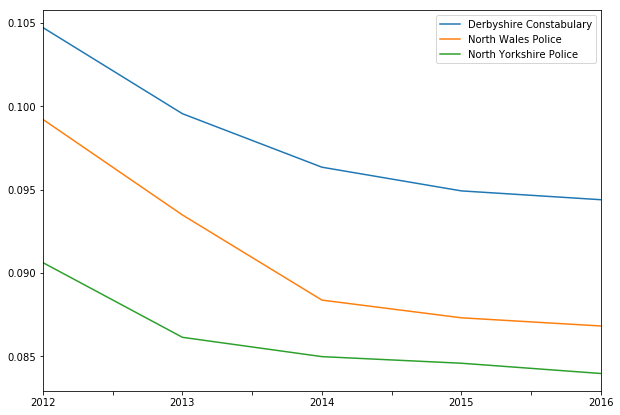

In [181]:
CrimeRateByForceFiveYears.transpose()[DecreasingRateForces].plot(figsize=(10,7))

<font size="4"><center><big><b>Breaking down the nature of the crimes</font></center></big></b>

What kind of crimes are we actually looking at?

In [14]:
TotalCrimeType = StreetData['Crime type'].value_counts()

In [15]:
TotalCrimeType

Anti-social behaviour           10321719
Violence and sexual offences     3599432
Other theft                      2838200
Criminal damage and arson        2726758
Burglary                         2178613
Vehicle crime                    1890686
Shoplifting                      1656885
Violent crime                     886252
Drugs                             872973
Public order                      692229
Other crime                       444616
Bicycle theft                     343226
Theft from the person             316945
Robbery                           288799
Public disorder and weapons       190590
Possession of weapons              91934
Name: Crime type, dtype: int64

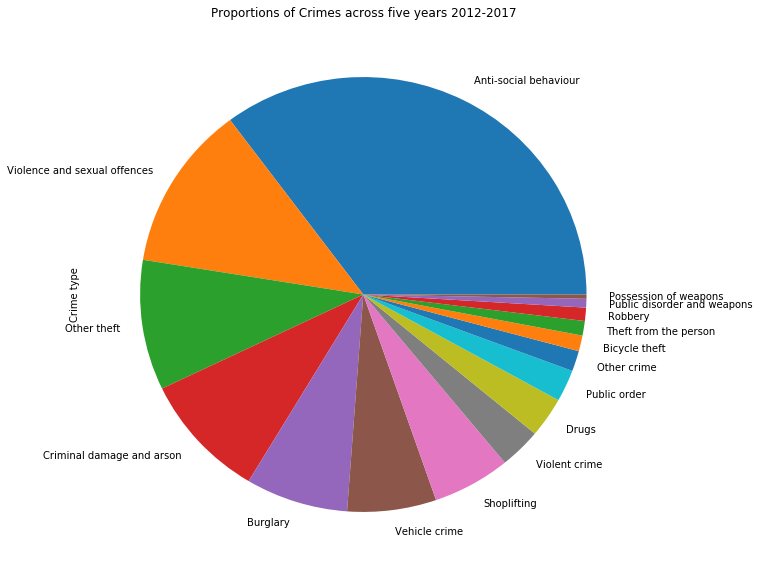

In [16]:
TotalCrimeType.plot(kind='pie',figsize=(10,10),title='Proportions of Crimes across five years 2012-2017')

To be continued...looking at this breakdown relative to Force, across time, and infographics

<font size="4"><center><big><b>Infographic of Serious Crimes across five years</font></center></big></b>

Here we produce a map of the UK with the police force boundaries shown, each coloured in a way corresponding to the rate of serious crime in that area. By serious crime, we mean Burglary, Other Theft, Violence and Sexual Offences, Criminal damage and arson, Vehicle Crime, Violent crime, and Theft from the person. The other crime categories, such as bicycle theft, whilst deplorable and unfortunate, are not really as serious as, say, arson (and some categories, such as "drugs", shouldn't really be crimes at all). 

We first collect the serious crime data.

In [17]:
SeriousStreetData = StreetData.rename(columns={'Crime type': 'crimetype'})

In [18]:
SeriousStreetData = SeriousStreetData.query('crimetype in ("Burglary","Other theft","Violence and sexual offences","Criminal damage and arson","Vehicle crime","Violent crime","Theft from the person")')

In [19]:
TotalSeriousCrimesByForce = SeriousStreetData['Reported by'].value_counts()
SeriousCrimeRateByForce = pd.concat([TotalSeriousCrimesByForce.sort_index(),Populations.sort_index()],axis=1)
SeriousCrimeRateByForce['Crime Rate']=SeriousCrimeRateByForce['Reported by']/SeriousCrimeRateByForce['Mid 2010']

As before, we'll remove the City of London, because it's clearly a special case. (What is going on there?)

In [20]:
SeriousCrimeRateByForceLite=SeriousCrimeRateByForce.drop('City of London Police')

In [21]:
SeriousCrimeRateByForceLite

,Reported by,Mid 2010,Crime Rate
Avon and Somerset Constabulary,405057,1623200.0,0.249542
Bedfordshire Police,147520,614800.0,0.239948
British Transport Police,111961,NaN,NaN
Cambridgeshire Constabulary,174801,789700.0,0.221351
Cheshire Constabulary,180031,1009300.0,0.178372
Cleveland Police,162195,563500.0,0.287835
Cumbria Constabulary,93125,494400.0,0.188360
Derbyshire Constabulary,204626,1010600.0,0.202480
Devon & Cornwall Police,317806,1680400.0,0.189125
Dorset Police,153751,715000.0,0.215036


Just to reiterate that we've made a few assumptions here; first, that the population has remained constant over the last five years; of course that's not true, but we feel any flucuation in population in a five-year period is negligible. Also, there is an implicit assumption that the socio-economic conditions and general crime rate in a region has remained constant over the last five years. This is a more problematic assumption; but some assumption along these lines is unavoidable in any such data analysis. 

We need to collect the max, min, and median rates. 

In [31]:
max_rate = np.max(SeriousCrimeRateByForceLite['Crime Rate'])
median_rate = np.nanmedian(SeriousCrimeRateByForceLite['Crime Rate'])
min_rate = np.min(SeriousCrimeRateByForceLite['Crime Rate'])

B = median_rate/max_rate #this will be useful later

The data giving the police force boundaries is available for download on the data.police.uk website, and one small discrepancy between this file and the crime data files are that, in the former, the Met is called "Metropolitan Police", whilst in the latter, it's called "Metropolitan Police Service". This small difference has to be ironed out. 

In [23]:
Dict = SeriousCrimeRateByForceLite['Crime Rate']
as_list = Dict.index.tolist()
idx = as_list.index('Metropolitan Police Service')
as_list[idx] = 'Metropolitan Police'
Dict.index = as_list

So now we're ready to make our infograph. We'll shade each area as a shade of darkred, the darker the shade, the higher the crime rate.

/Users/barinderbanwait/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


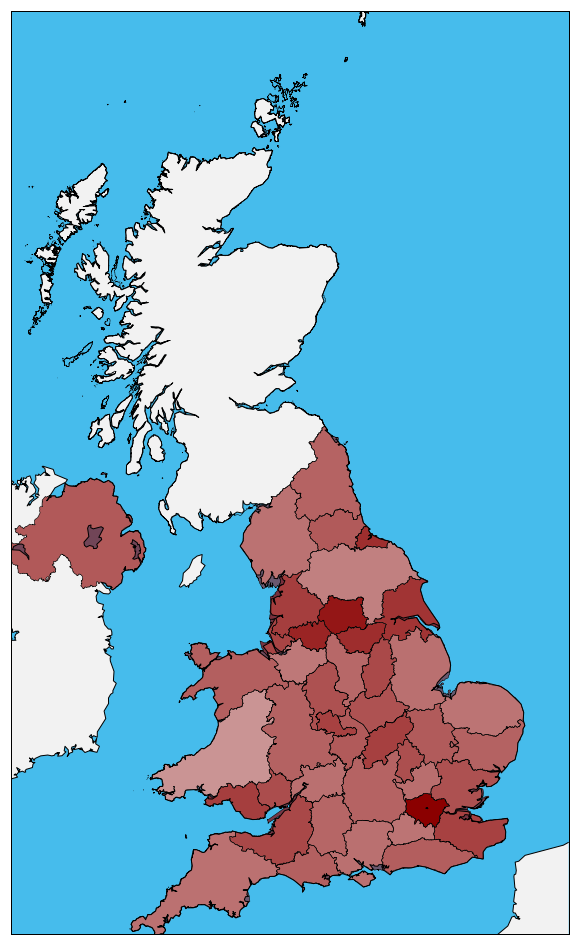

In [24]:
fig, ax = plt.subplots(figsize=(10,20))

m = Basemap(resolution='i', # c, l, i, h, f or None
            projection='merc',
            lat_0=55, lon_0=-3,
            llcrnrlon=-8, llcrnrlat= 50, urcrnrlon=2.6, urcrnrlat=60)
m.readshapefile("/Users/barinderbanwait/Downloads/borders2/SHP/UK_Police_Force_Areas", "borders")
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec',zorder = 0)
m.drawcoastlines()

state_patches = []
for coordinates, state in zip(m.borders, m.borders_info):
    if state["PFAFNAME"] in Dict.keys():
        shade = Dict[state["PFAFNAME"]]/max_rate
        state_patches.append(PolygonPatch(Polygon(coordinates), fc = "darkred", ec='#555555', lw=.2, alpha=shade, zorder=4))
    else:
        shade = 0
        state_patches.append(PolygonPatch(Polygon(coordinates), fc = "darkred", ec='#555555', lw=.2, alpha=shade, zorder=4))
                             
ax.add_collection(PatchCollection(state_patches, match_original=True))
#m.fillcontinents(color='#f2f2f2',lake_color='#46bcec',zorder = 0)

I was actually not too pleased with this; the shading is too similar, so one doesn't get a sense of how it changes. So I decided to change it up by colouring it in with two colours, red and yellow. Those forces where the crime rate was higher than the median were coloured red, and shaded accordingly (so, those just above the median were shaded light red, those near the max rate were shaded bright red), and those lower than the median were shaded yellow, the lower the brighter.

/Users/barinderbanwait/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


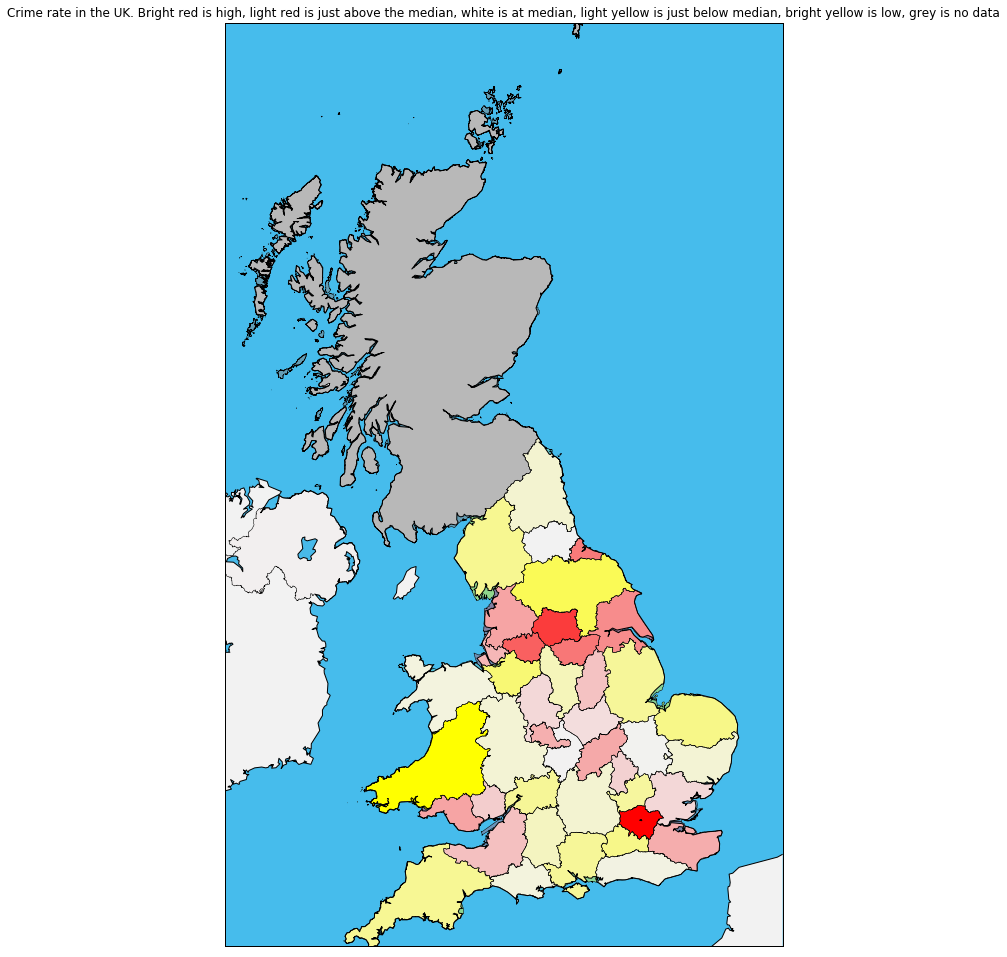

In [32]:
fig, ax = plt.subplots(figsize=(10,20))
#max_rate = numpy.max(Copy['crimerate'])

m = Basemap(resolution='i', # c, l, i, h, f or None
            projection='merc',
            lat_0=55, lon_0=-3,
            llcrnrlon=-8, llcrnrlat= 50, urcrnrlon=2.6, urcrnrlat=60)
m.readshapefile("/Users/barinderbanwait/Downloads/borders2/SHP/UK_Police_Force_Areas", "borders")
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec',zorder = 0)
m.drawcoastlines()

KEYS = Dict.keys()

state_patches = []
for coordinates, state in zip(m.borders, m.borders_info):
    if state["PFAFNAME"] in KEYS:
        if Dict[state["PFAFNAME"]] > median_rate:
            Inpy = Dict[state["PFAFNAME"]]/max_rate
            shade = Inpy + (B/(1-B))*(Inpy - 1)
            state_patches.append(PolygonPatch(Polygon(coordinates), fc = "red", ec='#555555', lw=.2, alpha=shade, zorder=4))
        elif Dict[state["PFAFNAME"]] == median_rate:
            shade = 0
            state_patches.append(PolygonPatch(Polygon(coordinates), fc = "red", ec='#555555', lw=.2, alpha=shade, zorder=4))
        else:
            shade = (median_rate - Dict[state["PFAFNAME"]])/(median_rate - min_rate)
            state_patches.append(PolygonPatch(Polygon(coordinates), fc = "yellow", ec='#555555', lw=.2, alpha=shade, zorder=4))
    else:
        shade = 0.5
        state_patches.append(PolygonPatch(Polygon(coordinates), fc = "grey", ec='#555555', lw=.2, alpha=shade, zorder=4))
                             
ax.add_collection(PatchCollection(state_patches, match_original=True))
plt.title("Crime rate in the UK. Bright red is high, light red is just above the median, white is at median, light yellow is just below median, bright yellow is low, grey is no data")